# Udacity Capstone Project - Arsenal's Invincibles' Defence

Arsenal's Invincibles season is unique to the Premier League, they are the only team that has gone a complete 38 game season without losing. They're considered to be one of the best teams ever to play in the Premier League. Going a whole season without losing suggests they were at least decent at defending, to reduce or completely remove bad luck from ruining their perfect record. This project aims to look into how Arsenal's defence managed this.

Using StatsBomb's public event data for the Arsenal 03/04 season* (33 games), I take a look at where Arsenal's defensive actions take place and how opponents attempted to progress the ball and create chances against them.

The goal is to identify areas of Arsenal's defensive strengths and the frequent approaches used by opponents. Tasks involved are as follows:

1. Download and preprocess StatsBomb's event data
2. Explore and visualise Arsenal's defensive actions
3. Explore and visualise Opponent's ball progression by thirds
4. Cluster and evaluate Opponent's ball progressions
5. Cluster and evaluate Opponent's shot creations

A major problem when using many clustering algorithms is identifying how many clusters exist in the data since they require that as an input parameter. Sometimes expert judgement can provide a good estimate. However, some clustering algorithms such as agglomerative clustering require other inputs such as distance thresholds to determine clusters.

When using k-means clustering, to determine the number of clusters the following metrics are used. When using agglomerative clustering, to determine the distance threshold the same metrics are used. They try to consider the density of points within clusters and between clusters.

1. **Sum of squares within cluster**:

Calculated using the inertia_ attribute of the k-means class, to compute the sum of squared distances of samples to their closest cluster center.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

2. **Silhouette Coefficient**:

Calculated using the mean intra-cluster distance and mean nearest-cluster distance for each sample. Best value is 1 and worst value is -1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

3. **Calinski-Harabasz Index**:

Known as the Variance Ratio Criterion, defined as the ratio between within-cluster dispersion and between-cluster dispersion. Higher scores signal clusters are dense and well separated.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html

4. **Davies-Bouldin Index**:

Average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Minimum score is 0, lower values for better clusters.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html

## Analysis

### Import Libraries

In [1]:
import json
from pandas.io.json import json_normalize
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

from CustomPitch import createVerticalPitch
from StatsBombPrep import ball_progression_events_into_thirds
from StatsBombViz import plot_sb_events, plot_sb_event_location, plot_sb_events_clusters, plot_individual_cluster_events
from StatsBombViz import plot_sb_event_grid_density_pitch, plot_histogram_ratio_pitch
from ClusterEval import kmeans_cluster, cluster_colour_map, cluster_evaluation, plot_cluster_evaluation

### Load StatsBomb Data

StatsBomb collect event data for lots of football matches and have made freely available a selection of matches (including all FAWSL) to allow amateur projects to be able to take place. All they ask is to sign up to their StatsBomb Public Data User Agreement here: https://statsbomb.com/academy/. And get access to the data via their GitHub here: https://github.com/statsbomb/open-data

Their data is stored in json files, with the event data for each match identifiable by their match ids. To get the relevant match ids, you can find those in the matches.json file. To get the relevant season and competitions, you can find that in the competitions.json file.


In [2]:
# Load competitions to find correct season and league codes
with open('open-data-master/data/competitions.json') as f:
    competitions = json.load(f)
    
competitions_df = pd.DataFrame(competitions)
competitions_df[competitions_df['competition_name'] == 'Premier League']

# Arsenal Invincibles Season
with open('open-data-master/data/matches/2/44.json', encoding='utf-8') as f:
    matches = json.load(f)

# Find match ids
matches_df = json_normalize(matches, sep="_")
match_id_list = matches_df['match_id']

# Load events for match ids
arsenal_events = pd.DataFrame()
for match_id in match_id_list:
    with open('open-data-master/data/events/'+str(match_id)+'.json', encoding='utf-8') as f:
        events = json.load(f)
    events_df = json_normalize(events, sep="_")
    events_df['match_id'] = match_id
    events_df = events_df.merge(matches_df[['match_id', 'away_team_away_team_name', 'away_score', 
                                            'home_team_home_team_name', 'home_score']],
                                on='match_id', how='left')    
    arsenal_events = arsenal_events.append(events_df)

print('Number of matches: '+ str(len(match_id_list)))


Number of matches: 33


### Data Preprocessing

Since we are working with event data, there is access to the pitch location in x, y coordinates of each recorded event. These are recorded as per their Pitch Coordinates found in the documentation: https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Events%20v4.0.0.pdf

The coordinates are mapped to a horizontal pitch with the origin (0, 0) in the top left corner, and (120, 80) in the bottom right. Since I am interested in defensive analysis from the point of view of Arsenal, I thought it would be easier to interpret if we converted these to a vertical pitch with Arsenal defending from the bottom and the opposition attacking downwards.

The location tuples for start and pass_end, carry_end are separated. They are all rotated to fit vertical pitch and then I create a universal end location for all progression events.

In [3]:
# Separate locations into x, y
arsenal_events[['location_x', 'location_y']] = arsenal_events['location'].apply(pd.Series)
arsenal_events[['pass_end_location_x', 'pass_end_location_y']] = arsenal_events['pass_end_location'].apply(pd.Series)
arsenal_events[['carry_end_location_x', 'carry_end_location_y']] = arsenal_events['carry_end_location'].apply(pd.Series)

# Create vertical locations
arsenal_events['vertical_location_x'] = 80 - arsenal_events['location_y']
arsenal_events['vertical_location_y'] = arsenal_events['location_x']
arsenal_events['vertical_pass_end_location_x'] = 80 - arsenal_events['pass_end_location_y']
arsenal_events['vertical_pass_end_location_y'] = arsenal_events['pass_end_location_x']
arsenal_events['vertical_carry_end_location_x'] = 80 - arsenal_events['carry_end_location_y']
arsenal_events['vertical_carry_end_location_y'] = arsenal_events['carry_end_location_x']

# Create universal end locations for event type
arsenal_events['end_location_x'] = np.where(arsenal_events['type_name'] == 'Pass',
                                            arsenal_events['pass_end_location_x'],
                                            np.where(arsenal_events['type_name'] == 'Carry',
                                                     arsenal_events['carry_end_location_x'],
                                                     np.nan))
arsenal_events['end_location_y'] = np.where(arsenal_events['type_name'] == 'Pass', 
                                            arsenal_events['pass_end_location_y'],
                                            np.where(arsenal_events['type_name'] == 'Carry', 
                                                     arsenal_events['carry_end_location_y'],
                                                     np.nan))
arsenal_events['vertical_end_location_x'] = np.where(arsenal_events['type_name'] == 'Pass',
                                                     arsenal_events['vertical_pass_end_location_x'],
                                                     np.where(arsenal_events['type_name'] == 'Carry', 
                                                              arsenal_events['vertical_carry_end_location_x'],
                                                              np.nan))
arsenal_events['vertical_end_location_y'] = np.where(arsenal_events['type_name'] == 'Pass', 
                                                     arsenal_events['vertical_pass_end_location_y'],
                                                     np.where(arsenal_events['type_name'] == 'Carry', 
                                                              arsenal_events['vertical_carry_end_location_y'],
                                                              np.nan))

As we are only interested in defensive events, we need to define the list of those. The full list of available events is located in the events documentation above. 

I have defined all defensive events to use throughout below and filtered all events for those. Due to the nature of event data, these are all on-ball defensive actions. Often defensive plays are off-ball and explicitly deny future events from taking place, so these events may only highlight the end point of a potential sequence of 'invisible' defensive plays.

In [4]:
defensive_actions_list = ['Clearance', 'Pressure', 'Duel', 'Ball Recovery',
                          'Foul Committed', 'Block', 'Interception', '50/50']
defensive_actions = arsenal_events[arsenal_events['type_name'].isin(defensive_actions_list)]
arsenal_defensive_actions = arsenal_events[(arsenal_events['team_name'] == 'Arsenal') & 
                                           (arsenal_events['type_name'].isin(defensive_actions_list))]
opponents_defensive_actions = arsenal_events[(arsenal_events['team_name'] != 'Arsenal') & 
                                             (arsenal_events['type_name'].isin(defensive_actions_list))]

Since event data cannot tell the full defensive story, taking a look at the opposition's offensive plays may help. 

Firstly I remove all set pieces in favour of keeping only open play progressions. This is because defending from open play and set pieces requires different approaches, I will be focusing on open play progressions here.

Need to define what event types we class as ball progressions too. Here I have defined passes, carries and dribbles. The difference between a Carry and a Dribble is that a Dribble is 'an attempt by a player to beat an opponent', whilst a Carry is defined as 'a player controls the ball at their feet while moving or standing still.' In the data this distinction is clearer since a Carry has a start and end point, whilst a Dribble starts and ends in the same place.

The defined list of ball progression columns were aspirational and things I think would be useful to consider for next time, but didn't get to look further into.

As mentioned above, when using the vertical pitch it would be useful to have the opponents moving in the opposite direction to the defending team (Arsenal) to feel more interpretable when visualising.

I have separated the ball progressions into thirds on the pitch since different approaches may be taken in different areas of the pitch. More caution would be expected closer to your own goal than in the opponents third.

Narrowing down more towards goal threatening progressions I've separated out passes and carries into the penalty area and shot assists.

Finally, dribbles are considered separately since they don't have a separate end location. There is more focus on the progressions via passes and carries since they have quantifiable start to end progressions up the pitch.

In [5]:
# Remove Set Pieces
open_play_patterns = ['Regular Play', 'From Counter', 'From Keeper']
arsenal_open_play = arsenal_events[arsenal_events['play_pattern_name'].isin(open_play_patterns)]

# Define Opponents Ball Progression
event_types = ['Pass', 'Carry', 'Dribble']
ball_progression_cols = [
    'id', 'player_name', 'period', 'possession', 'duration', 'type_name', 
    'possession_team_name', 'team_name', 'play_pattern_name', 
    'vertical_location_x', 'vertical_location_y', 'vertical_end_location_x', 'vertical_end_location_y',
    'pass_length', 'pass_angle', 'pass_height_name', 
    'pass_body_part_name', 'pass_type_name', 'pass_outcome_name', 
    'ball_receipt_outcome_name', 'pass_switch', 'pass_technique_name',
    'pass_cross', 'pass_through_ball', 
    'pass_shot_assist', 'shot_statsbomb_xg', 'pass_goal_assist', 'pass_cut_back', 'under_pressure'
    ]

# Filter Opponents and Ball Progression Columns
opponent_ball_progressions = arsenal_open_play[(arsenal_open_play['team_name'] != 'Arsenal') & 
                                               (arsenal_open_play['type_name'].isin(event_types))]
opponent_ball_progressions = opponent_ball_progressions[ball_progression_cols]

# Reverse locations for opponents
opponent_ball_progressions['vertical_location_x'] = 80-opponent_ball_progressions['vertical_location_x']
opponent_ball_progressions['vertical_location_y'] = 120-opponent_ball_progressions['vertical_location_y']
opponent_ball_progressions['vertical_end_location_x'] = 80-opponent_ball_progressions['vertical_end_location_x']
opponent_ball_progressions['vertical_end_location_y'] = 120-opponent_ball_progressions['vertical_end_location_y']

# Separate events into thirds, penalty area
from_own_third_opp, from_mid_third_opp, from_final_third_opp, into_pen_area_opp = \
    ball_progression_events_into_thirds(opponent_ball_progressions)

# Filter shot assists
opponent_shot_assists = opponent_ball_progressions[opponent_ball_progressions['pass_shot_assist'] == True]

# Filter dribbles
opponent_dribbles = opponent_ball_progressions[opponent_ball_progressions['type_name'] == 'Dribble']

### Data Exploration

This is an incredible sparse dataset, there are lots of events and lots of categorical columns to provide much needed context. Most columns aren't applicable to most events so there are lots of missing or uninteresting values.

In [6]:
arsenal_defensive_actions.isnull().sum().sort_values(ascending=False)

vertical_end_location_y     10251
goalkeeper_end_location     10251
goalkeeper_type_name        10251
goalkeeper_position_id      10251
goalkeeper_position_name    10251
                            ...  
home_team_home_team_name        0
away_score                      0
away_team_away_team_name        0
match_id                        0
id                              0
Length: 161, dtype: int64

The most frequent defensive action is a Pressure. Pressures don't always result in a turnover, whereas Ball Recovery or Interception would. 

In [7]:
arsenal_defensive_actions.groupby('type_name').count()['id']

type_name
50/50               20
Ball Recovery     2020
Block              573
Clearance         1096
Duel              1338
Foul Committed     528
Interception       258
Pressure          4418
Name: id, dtype: int64

There are lots more Carries and Passes than Dribbles, but I expected there to be more Passes relative to Carries than there are.

In [8]:
opponent_ball_progressions.groupby('type_name').count()['id']

type_name
Carry      5352
Dribble     327
Pass       6398
Name: id, dtype: int64

There are lots more progressions via Passes than Carries in the opposition's own third and middle third. This is likely due to the reduced risk of a forward pass compared to a carry. If you lose the ball due to a misplaced pass, the ball is likely higher up the field and the passer is closer to their own goal as an extra defender. If you lose the ball due to being tackled, then you likely lose the ball from where you are and are chasing back to catch up.

In [9]:
from_own_third_opp.groupby('type_name').count()['id']

type_name
Carry    148
Pass     833
Name: id, dtype: int64

In [10]:
from_mid_third_opp.groupby('type_name').count()['id']

type_name
Carry    172
Pass     676
Name: id, dtype: int64

In the final third, there is a much more even split between Carries and Passes. Perhaps due to forward passing becoming much harder the further up the pitch and the reduced risk of Carries since you are so far away from your own goal.

In [11]:
from_final_third_opp.groupby('type_name').count()['id']

type_name
Carry    488
Pass     531
Name: id, dtype: int64

Although Carries are good at getting near the penalty area, Passes are still the main way into the penalty area.

In [12]:
into_pen_area_opp.groupby('type_name').count()['id']

type_name
Carry     85
Pass     351
Name: id, dtype: int64

And well assists are a subset of passes so no Carries here..

In [13]:
opponent_shot_assists.groupby('type_name').count()['id']

type_name
Pass    81
Name: id, dtype: int64

### Data Visualisation

Looking at all defensive events from Arsenal across the season leads to an overplotting mess. It's pretty hard to tell anything from this.

(<Figure size 360x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27d99798828>)

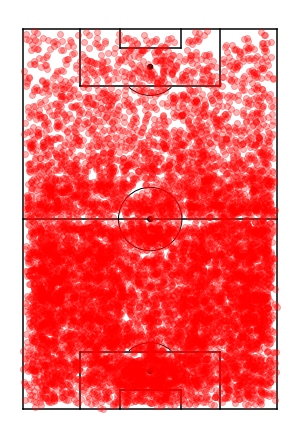

In [14]:
plot_sb_event_location(arsenal_defensive_actions, alpha = 0.3)

Looking at all of the opponent's ball progressions is arguably even worse.

(<Figure size 360x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27daea3a1d0>)

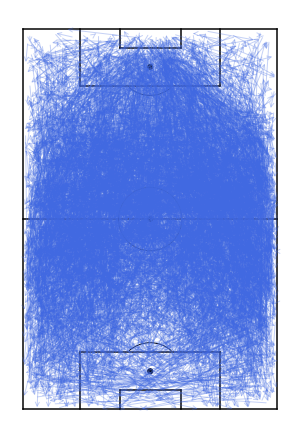

In [15]:
plot_sb_events(opponent_ball_progressions, alpha = 0.3)

Due to the lower volume, we can actually see that there are more dribbles out wide than centrally.

(<Figure size 360x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27db36c0be0>)

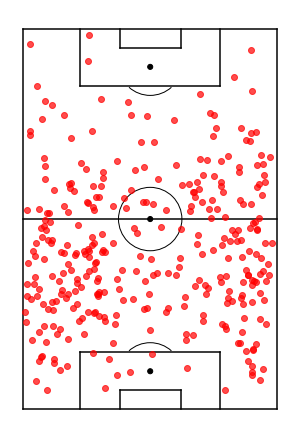

In [16]:
plot_sb_event_location(opponent_dribbles)

## Methodology

Event data records all on-ball actions from a match, this is more granular than high level team and player totals. As well as the event types, the event locations and extra information for the respective event type are recorded to provide context where possible. For offensive events such as passing and shooting, event data is great since they are usually on-ball actions. There are on-ball defensive actions such as tackles, interceptions and recoveries which are well captured by event data, these are the defensive events that I will be using. Using these defensive events, we can see where these events frequently occur on the pitch for Arsenal compared to their opposition. The key nuance is that just because these are the defensive events recorded, doesn't mean they are all of the defensive plays that take place on the pitch.

The hard part about defensive analysis is that a large proportion of defending are non-events and won't be captured by event data. If an opportunity to pass the ball to your striker is removed due to a defensive player blocking the passing lane, that pass will not happen and will not be recorded as such. The effective defensive play was to deny a potential event taking place for the offensive team.

Using event data to evaluate defenses can be done by using a combination of the defensive events from Arsenal and the offensive actions from Arsenal's opponents. Arsenal's defensive events will show where their on-ball defending took place. Arsenal's opponents' offensive events will show how they approached attacking Arsenal, this may be the offensive team getting their way or Arsenal's defence forcing opponents to play in a certain way. From Arsenal's success, the majority of the time it's the latter.

To look at Arsenal's defensive events, I plot the defensive events in a gridded 2D histogram across the pitch with marginal density plots along each axis to highlight areas of high activity. The same is done for Arsenal's opponents and the differences can be highlighted using the ratio.

To look at Arsenal's opponents events, I specifically look at ball progression including passes, carries and dribbles. These are separated into similar locations on the pitch since different approaches will be required:

1. From their own third forwards
2. From the middle third forwards
3. From the final third forwards
4. Into the penalty area
5. Shot assists

These categories of ball progressions are clustered using K-Means on the start and end locations to group similar ball progressions for each area of the pitch. The assumed number of clusters is decided using expert judgement and four evaluation measures:

1. Sum of squared variance within cluster
2. Silhouette Coefficient
3. Calinski-Harabasz Index
4. Davies-Bouldin Index

These clusters will represent the approaches that opponents tried to attack and create chances against Arsenal. No concrete results will be able to be drawn from only this, but they will give a better understanding.

## Defensive Events

Text(10, 10, '')

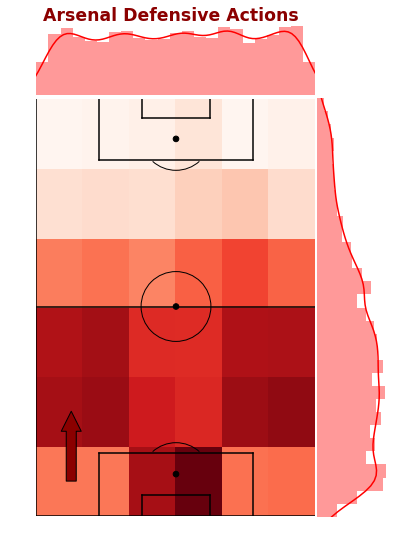

In [17]:
# Arsenal Defensive Events Density Grid
fig, ax, ax_histx, ax_histy = plot_sb_event_grid_density_pitch(arsenal_defensive_actions)

# Title
fig.suptitle("Arsenal Defensive Actions",
             x=0.5, y=0.92,
            fontsize = 'xx-large', fontweight='bold',
            color = 'darkred')

# Direction of play arrow
ax.annotate("",
            xy=(10, 30), xycoords='data',
            xytext=(10, 10), textcoords='data',
            arrowprops=dict(width=10,
                            headwidth=20,
                            headlength=20,
                            edgecolor='black',
                            facecolor = 'darkred',
                            connectionstyle="arc3")
            )

Rather than the overplotting mess we saw above, the above plot is a combination of a 2D histogram grid and marginal density plots across each axis. We can see that the frequency of defensive actions is evenly spread left to right and more heavily skewed to their own half.

More specifically, the highest action areas are in front of their own goal and out wide in the full back areas above the penalty area. Defensive actions in their own penalty area are expected as that the closest to your goal and crosses into the box are dealt with. 

The full back areas seem to be more proactive in making defensive actions before the opponent gets closer to the byline. Passes and cutbacks from these areas close to the byline and penalty are usually generate high quality shooting chances, so minimising the opponents ability to get here is great.

Text(10, 10, '')

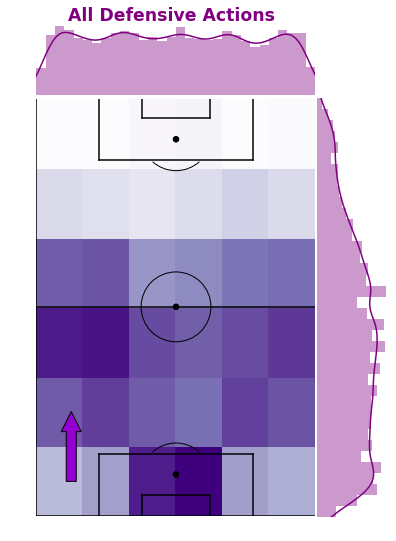

In [18]:
# All Defensive Events Density Grid
fig, ax, ax_histx, ax_histy = plot_sb_event_grid_density_pitch(defensive_actions,
                                                               grid_colour_map = 'Purples',
                                                               bar_colour = 'purple')

# Title
fig.suptitle("All Defensive Actions",
             x=0.5, y=0.92,
            fontsize = 'xx-large', fontweight='bold',
            color = 'purple')

# Direction of play arrow
ax.annotate("",
            xy=(10, 30), xycoords='data',
            xytext=(10, 10), textcoords='data',
            arrowprops=dict(width=10,
                            headwidth=20,
                            headlength=20,
                            edgecolor='black',
                            facecolor = 'darkviolet',
                            connectionstyle="arc3")
            )


Here we have all defensive events across the matches that Arsenal were in, so Arsenal will be a major contributor to these frequencies. It's interesting to see the events still largely take place in their own penalty area, but less so in the full back areas.

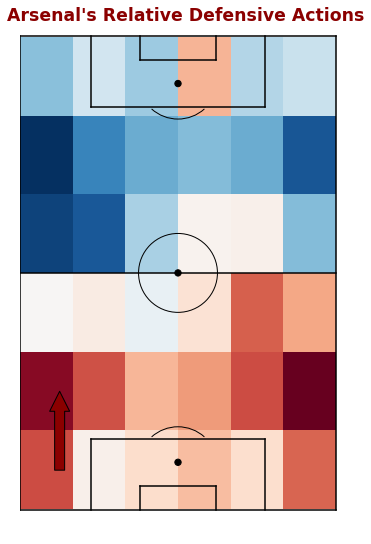

In [19]:
# Relative Grid Density
fig, ax = plot_histogram_ratio_pitch(arsenal_defensive_actions, defensive_actions)

fig.suptitle("Arsenal's Relative Defensive Actions",
             x=0.5, y=0.87,
            fontsize = 'xx-large', fontweight='bold',
            color = 'darkred')
ax.annotate("",
            xy=(10, 30), xycoords='data',
            xytext=(10, 10), textcoords='data',
            arrowprops=dict(width=10,
                            headwidth=20,
                            headlength=20,
                            edgecolor='black',
                            facecolor = 'darkred',
                            connectionstyle="arc3")
            )
fig.tight_layout()

Whilst seeing all defensive events gave some insight into what everyone was doing overall, we can also take a look at the relative difference between Arsenal's defensive events and the overall view. This density grid shows where Arsenal had more events than overall in red and less than overall in blue. 

The darkest red areas are again the full back areas, suggesting that Arsenal's full backs performed more on-ball defensive actions than their opponents. Whereas they defended their penalty area about as evenly as opponents and less frequently in their opponent's half.

By taking a look at opponent's ball progressions we can get potentially see the opponent's point of view here. Do Arsenal's full back areas have so many defensive events because they are 'funneling' their opponents there as they see it as a strength or do Arsenal's opponents target and exploit their full back areas?

## Ball Progression

### Own Third

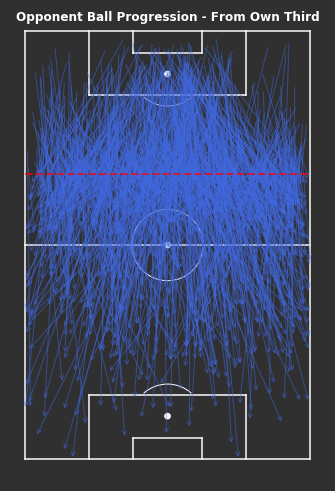

In [20]:
# From Own Third - Ball Progressions
fig, ax = plot_sb_events(from_own_third_opp, alpha = 0.5, figsize = (5, 10), pitch_theme='dark')

# Set figure colour to dark theme
fig.set_facecolor("#303030")
# Title
ax.set_title("Opponent Ball Progression - From Own Third",
             fontdict = dict(fontsize=12,
                             fontweight='bold',
                             color='white'),
            pad=-10)
# Dotted red line for own third
ax.hlines(y=80, xmin=0, xmax=80, color='red', alpha=0.7, linewidth=2, linestyle='--', zorder=5)
plt.tight_layout()

Even whilst only looking at the ball progressions from their own third, it's still hard to identify any trends or patterns of play. There are lots of longer passes, though I have only included progressions of at least 10 yards. 

Text(0.5, 0.98, 'Cluster Evaluation - From Own Third')

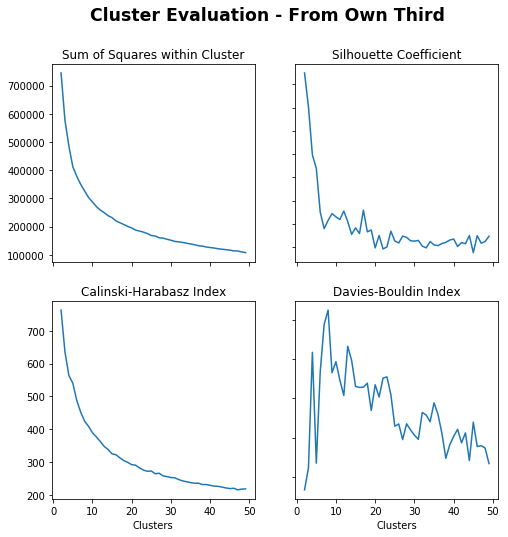

In [21]:
# Create cluster evaluation dataframe for up to 50 clusters
own_third_clusters = cluster_evaluation(from_own_third_opp, 50)

# Plot cluster evaluation metrics by cluster number
title = "Cluster Evaluation - From Own Third"
fig, axs = plot_cluster_evaluation(own_third_clusters)
fig.suptitle(title,
            fontsize = 'xx-large', fontweight='bold')

For K-Means, across each metric it looks as though the ideal number of clusters is roughly 15, I will choose 16 for a 4x4 grid.

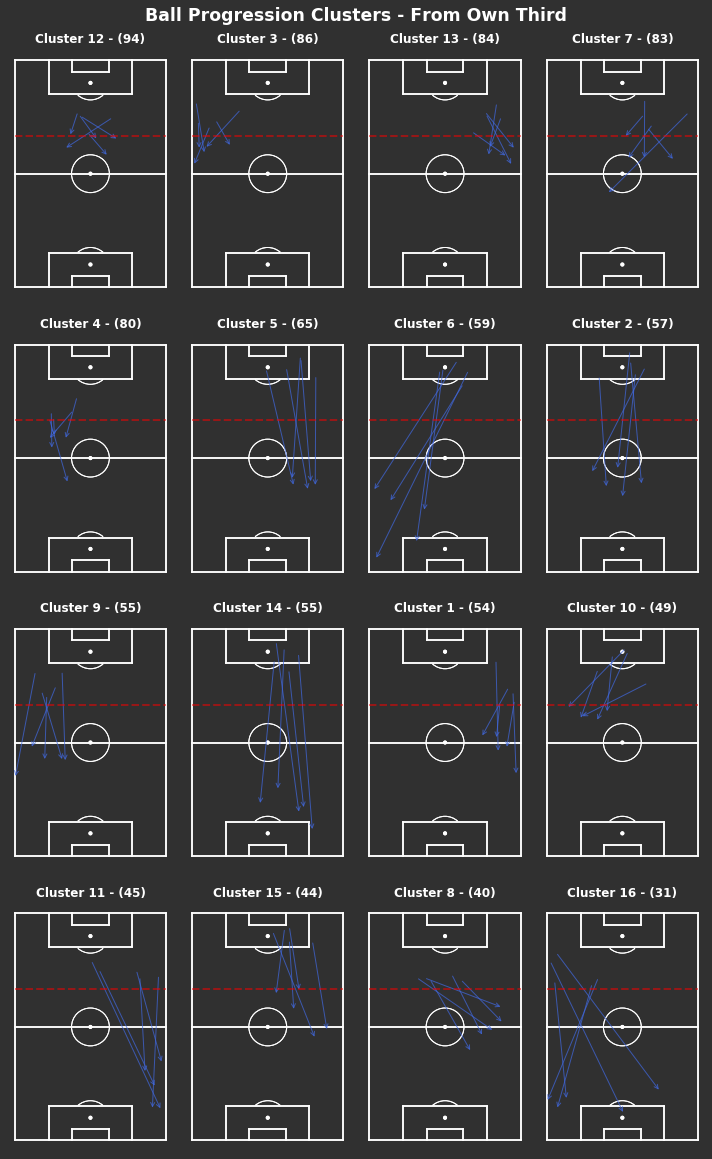

In [22]:
np.random.seed(1000)

# KMeans based on chosen number of clusters
cluster_labels_own_third = kmeans_cluster(from_own_third_opp, 16)

# Plot each cluster
title = "Ball Progression Clusters - From Own Third"
fig, axs = plot_individual_cluster_events(4, 4, from_own_third_opp, cluster_labels_own_third)
# Title
fig.suptitle(title,
             fontsize = 'xx-large', fontweight='bold',
             color = 'white',
             x=0.5, y=1.01)
# Dotted red lines for own third across all axes
for ax in axs.flatten():
    ax.hlines(y=80, xmin=0, xmax=80, color='red', alpha=0.5, linewidth=2, linestyle='--', zorder=5)


We find that the most frequent cluster types for progressing the ball from their own third are shorter progressions into the middle third. There are short progressions centrally in clusters 12 and 7, with wider progressions in clusters 3 and 13.

Shorter progressions are easier to complete and less risky, so not surprising that they are the most frequent. This says nothing for how quality or sustainable these progressions are. 

### Middle Third

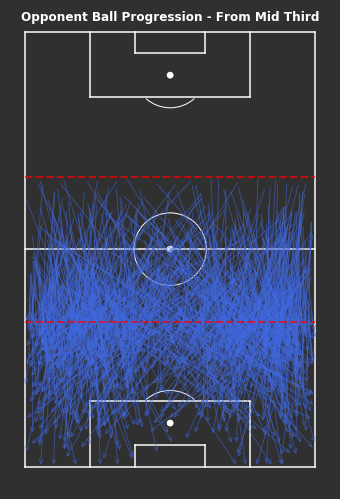

In [23]:
# From Mid Third - Ball Progressions
fig, ax = plot_sb_events(from_mid_third_opp, alpha = 0.5, figsize = (5, 10), pitch_theme='dark')

# Set figure colour to dark theme
fig.set_facecolor("#303030")
# Title
ax.set_title("Opponent Ball Progression - From Mid Third",
             fontdict = dict(fontsize=12,
                             fontweight='bold',
                             color='white'),
            pad=-10)
# Dotted red lines for middle third
ax.hlines(y=[40, 80], xmin=0, xmax=80, color='red', alpha=0.7, linewidth=2, linestyle='--', zorder=5)
fig.tight_layout()

Ball progressions from the middle third seem to have trajectories that are more dense out wide, so the ball rarely travels through the middle of the pitch in Arsenal's own third. This may be another indicator that the ball is being directed outside, likely because there are lots of players located centrally.

Text(0.5, 0.98, 'Cluster Evaluation - From Mid Third')

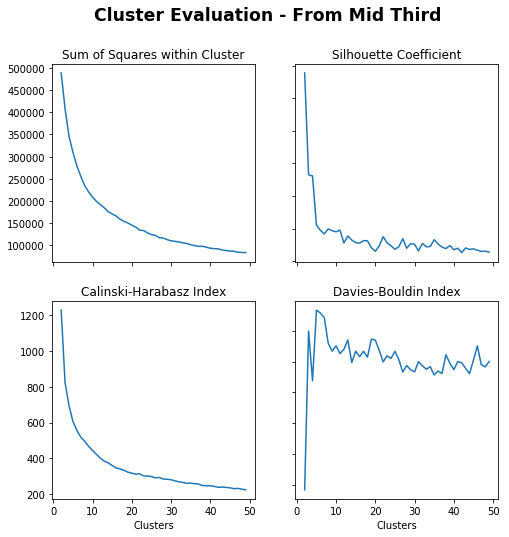

In [24]:
# Create cluster evaluation dataframe for up to 50 clusters
mid_third_clusters = cluster_evaluation(from_mid_third_opp, 50)

# Cluster Evaluations - From Mid Third
title = "Cluster Evaluation - From Mid Third"
fig, axs = plot_cluster_evaluation(mid_third_clusters)
fig.suptitle(title,
            fontsize = 'xx-large', fontweight='bold')

For progressions from the middle third, the ideal number of clusters looks to be roughly 10. I choose 9 for a 3x3 grid.

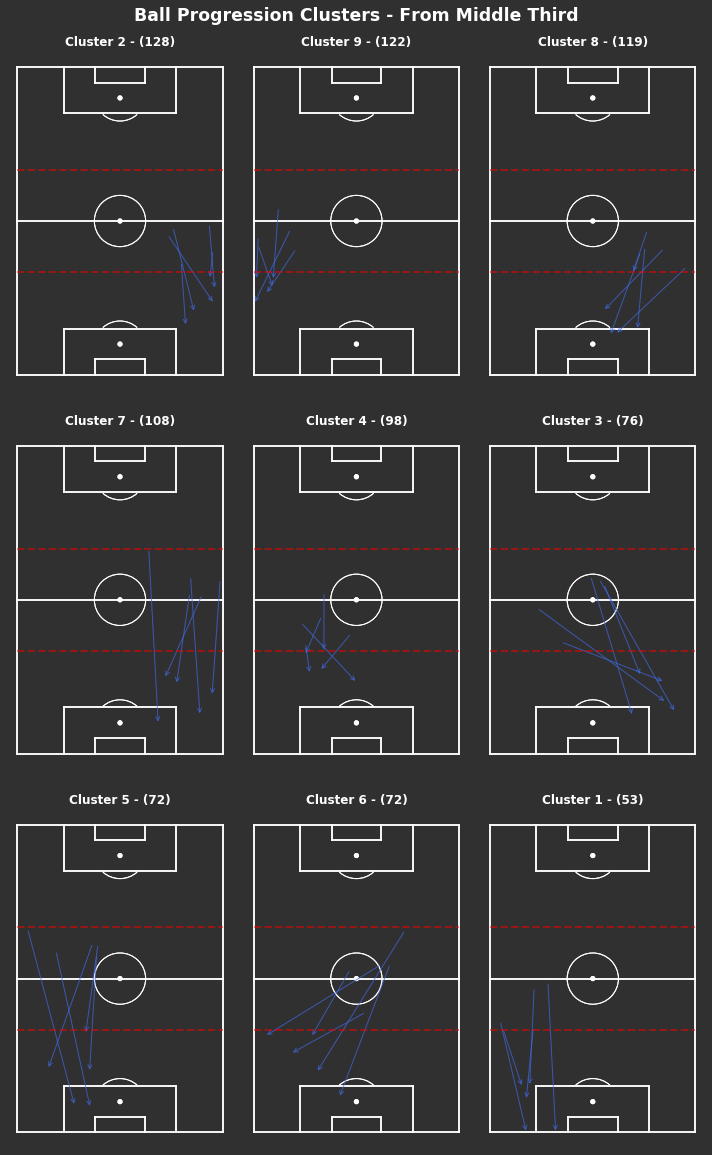

In [25]:
np.random.seed(1000)

# KMeans based on chosen number of clusters
cluster_labels_mid_third = kmeans_cluster(from_mid_third_opp, 9)

# Clustered Ball Progressions - From Mid Third
fig, axs = plot_individual_cluster_events(3, 3, from_mid_third_opp, cluster_labels_mid_third)
# Title
fig.suptitle("Ball Progression Clusters - From Middle Third",
             fontsize = 'xx-large', fontweight='bold',
             color = 'white',
             x=0.5, y=1.01)
# Dotted red lines for middle third across all axes
for ax in axs.flatten():
    ax.hlines(y=[40,80], xmin=0, xmax=80, color='red', alpha=0.5, linewidth=2, linestyle='--', zorder=5)

Similar to the progressions from their own third, the most frequent progressions from the middle third are shorter down the wide areas in clusters 2 and 9, with some longer progressions in clusters 7 and 5. Clusters 8 and 4 suggest a number of progressions do make it into the centre of Arsenal's own half.

### Final Third

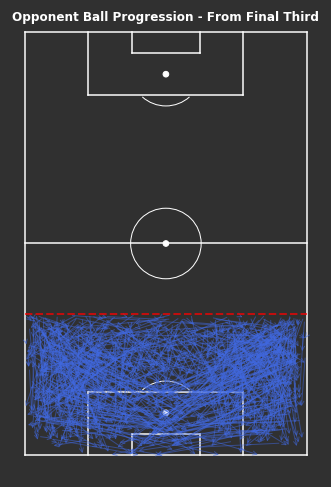

In [26]:
# From Final Third - Ball Progressions
fig, ax = plot_sb_events(from_final_third_opp, alpha = 0.5, figsize = (5, 10), pitch_theme = 'dark')

# Set figure colour to dark theme
fig.set_facecolor("#303030")
# Title
ax.set_title("Opponent Ball Progression - From Final Third",
             fontdict = dict(fontsize=12,
                             fontweight='bold',
                             color='white'),
            pad=-10)
# Dotted red line for final third
ax.hlines(y=40, xmin=0, xmax=80, color='red', alpha=0.7, linewidth=2, linestyle='--', zorder=5)
fig.tight_layout()

Once in the final third, the progressions are less vertically direct. Hard to tell here, but looks like lots of shorter progressions and longer direct progressions into the box, likely crosses.

Text(0.5, 0.98, 'Cluster Evaluation - From Final Third')

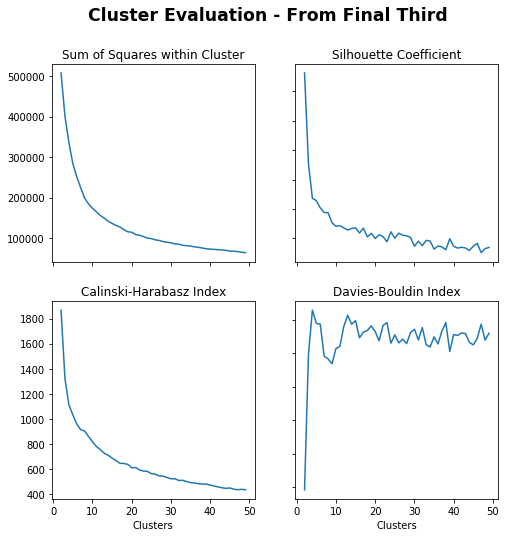

In [27]:
# Create cluster evaluation dataframe for up to 50 clusters
final_third_clusters = cluster_evaluation(from_final_third_opp, 50)

# Cluster Evaluations - From Final Third
fig, axs = plot_cluster_evaluation(final_third_clusters)
fig.suptitle("Cluster Evaluation - From Final Third",
            fontsize = 'xx-large', fontweight='bold')

For progressions from the final third, the ideal number of clusters looks to be roughly 10. I choose 9 for a 3x3 grid.

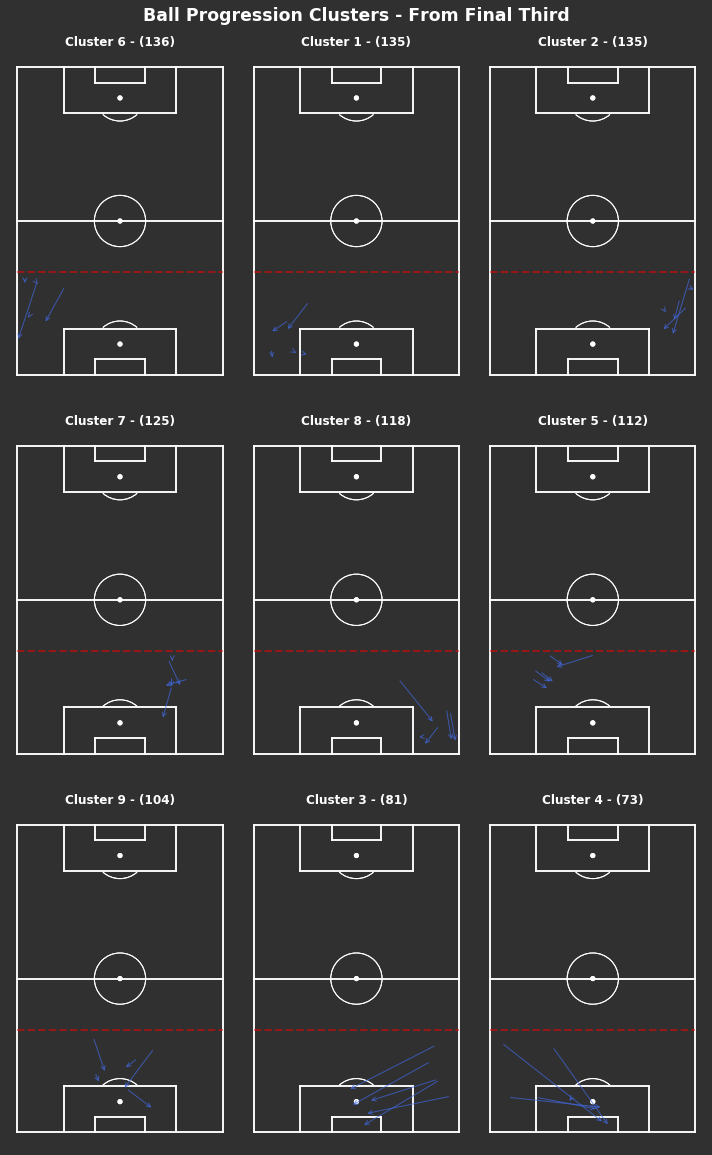

In [28]:
np.random.seed(1000)

# KMeans based on chosen number of clusters
cluster_labels_final_third = kmeans_cluster(from_final_third_opp, 9)

# Plot clusters individually
fig, axs = plot_individual_cluster_events(3, 3, from_final_third_opp, cluster_labels_final_third)
fig.suptitle("Ball Progression Clusters - From Final Third",
             fontsize = 'xx-large', fontweight='bold',
             color = 'white',
             x=0.5, y=1.01)
# Dotted red lines for final third across all axes
for ax in axs.flatten():
    ax.hlines(y=40, xmin=0, xmax=80, color='red', alpha=0.5, linewidth=2, linestyle='--', zorder=5)

Again, the most frequent progressions appear to be short and out wide all clusters except 3 and 4. Clusters 3 and 4 are the least frequent, but are consistent in entering the penalty area.

### Penalty Area

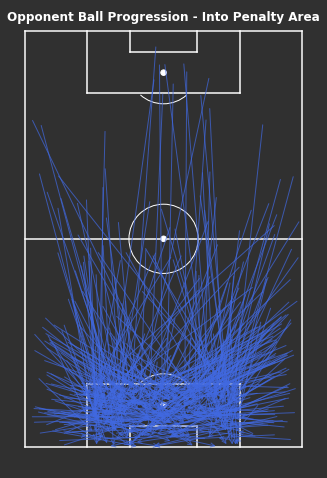

In [29]:
# Into Penalty Area - Ball Progressions
fig, ax = plot_sb_events(into_pen_area_opp, alpha = 0.7, figsize = (5, 10), pitch_theme = 'dark')

# Set figure colour to dark theme
fig.set_facecolor("#303030")
# Title
ax.set_title("Opponent Ball Progression - Into Penalty Area",
             fontdict = dict(fontsize=12,
                             fontweight='bold',
                             color='white'),
            pad=-10)
fig.tight_layout()

The majority of progressions into the penalty area come from out wide, however there are some that are incredibly direct and even from their own half.

Text(0.5, 0.98, 'Cluster Evaluation - Into Penalty Area')

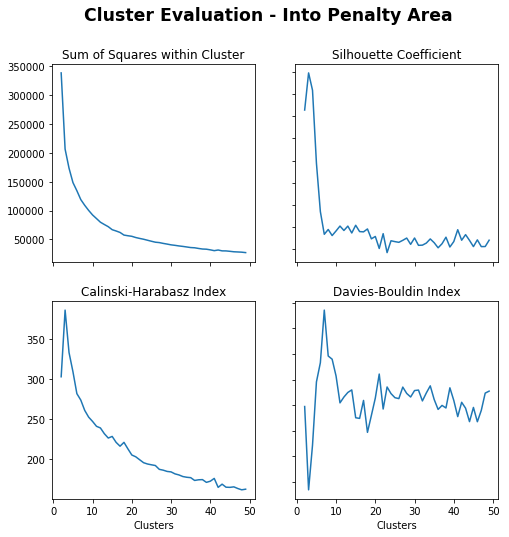

In [30]:
# Create cluster evaluation dataframe for up to 50 clusters
pen_area_clusters = cluster_evaluation(into_pen_area_opp, 50)

# Cluster Evaluations - Into Pen Area
fig, axs = plot_cluster_evaluation(pen_area_clusters)
# Title
fig.suptitle("Cluster Evaluation - Into Penalty Area",
            fontsize = 'xx-large', fontweight='bold')

For progressions into the penalty area, the ideal number of clusters looks to be roughly 10. I choose 9 for a 3x3 grid.

Text(0.5, 1.01, 'Ball Progression Clusters - Into Penalty Area')

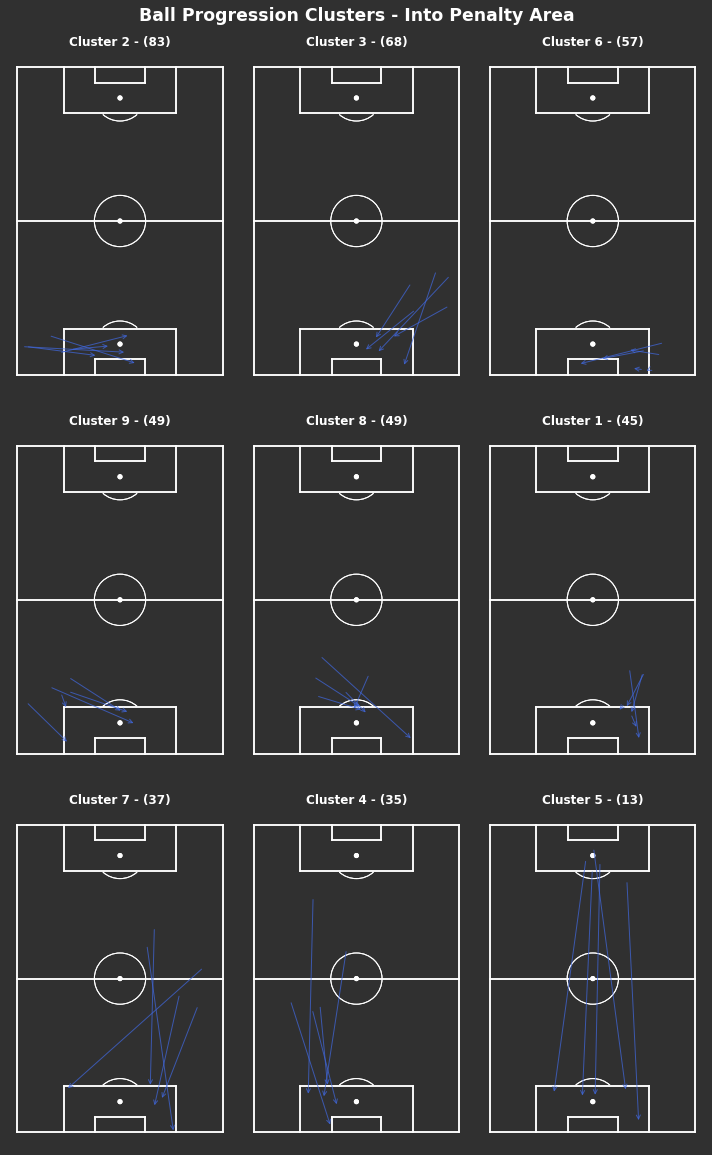

In [31]:
np.random.seed(1000)

# KMeans based on chosen number of clusters
cluster_labels_pen_area = kmeans_cluster(into_pen_area_opp, 9)

# Plot individual clusters
fig, axs = plot_individual_cluster_events(3, 3, into_pen_area_opp, cluster_labels_pen_area, sample_size=5)
# Title
fig.suptitle("Ball Progression Clusters - Into Penalty Area",
             fontsize = 'xx-large', fontweight='bold',
             color = 'white',
             x=0.5, y=1.01)

For penalty area entries, most are from out wide in the full back areas, and close to the by line in clusters 2 and 6. These are generally areas that provide quality penalty area entries, you want to minimize these as much as possible.

### Shot Assists

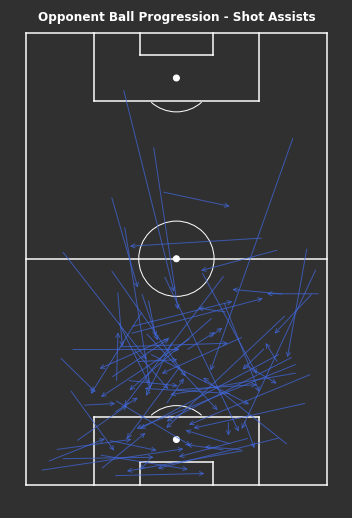

In [32]:
# Shot Assist
fig, ax = plot_sb_events(opponent_shot_assists, pitch_theme = 'dark')

# Set figure colour to dark theme
fig.set_facecolor("#303030")
# Title
ax.set_title("Opponent Ball Progression - Shot Assists",
             fontdict = dict(fontsize=12,
                             fontweight='bold',
                             color='white'),
            pad=-10)
fig.tight_layout()

Shot assists seem to be largely random, the criteria of having a shot attached to the end of the pass is incredible strict and contextual to other players.

Text(0.5, 0.98, 'Cluster Evaluation - Shot Assists')

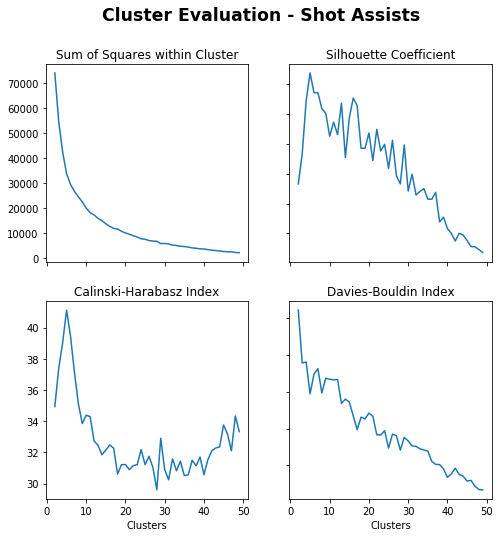

In [33]:
# Create cluster evaluation dataframe for up to 50 clusters
shot_assist_clusters = cluster_evaluation(opponent_shot_assists, 50)

# Cluster Evaluations - Shot Assists
fig, axs = plot_cluster_evaluation(shot_assist_clusters)
fig.suptitle("Cluster Evaluation - Shot Assists",
            fontsize = 'xx-large', fontweight='bold')

For shot assists, the ideal number of clusters looks to be roughly 10. I choose 9 for a 3x3 grid.

Text(0.5, 1.01, 'Ball Progression Clusters - Shot Assists')

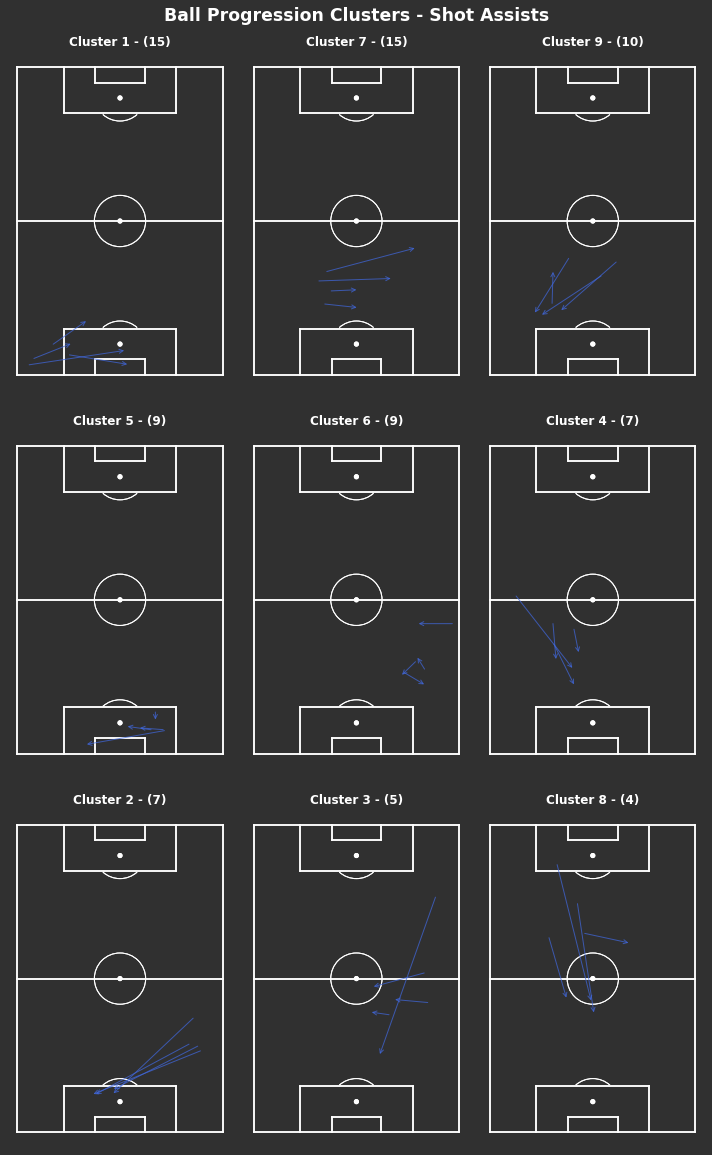

In [34]:
np.random.seed(1000)

# KMeans based on chosen number of clusters
cluster_labels_shot_assist = kmeans_cluster(opponent_shot_assists, 9)

# Clustered Ball Progressions - Shot Assists 
fig, axs = plot_individual_cluster_events(3, 3, opponent_shot_assists, cluster_labels_shot_assist, sample_size=4)
# Title
fig.suptitle("Ball Progression Clusters - Shot Assists",
             fontsize = 'xx-large', fontweight='bold',
             color = 'white',
             x=0.5, y=1.01)

When looking at only shot assists, there are lots from the left full back area as well as passes through the middle. Both of these are areas where if you can complete a pass towards goal then there is a higher chance of generating a shot. However, shot assists that do not penetrate the penalty area suggest that those shots are likely from further out and of lower quality.

Again, there is no indication as to the quality of these shots produced and there is no context to compare to the wider league. But what is promising is that there is nothing significant standing out and and the common breaches of the Arsenal defence are just good progressions if they do come off. It's not clear here how many more of these types of opportunities that were prevented due to defensive plays off the ball.

## Overview

### Opponent's Ball Progressions

Across ball progressions throughout the whole pitch, the most frequent were shorter and in the wide areas. This is expected as shorter progressions are lower risk and wide areas are less important to defend, so are areas the defending team are willing to concede.

The length of progressions from the middle third appear to be longer than in their own third or in the final third. Context is needed in all individual circumstances but this may be due to a lower risk of failure due to being further away from your own goal or trying to take advantage of a short window of opportunity to quickly progress the ball longer distances into the final third.

When in the final third, the progressions shorten again. This is not due to lower risk, but likely due to a more densely populated area. There will be the majority of all players on the pitch within a single half of the pitch, navigating through there requires precision and patience from the offensive team.

Any completed progression into the penalty area is a success for the offensive team. There is a high chance you will create a shot and if you do it's likely to be a higher quality shot than from outside the penalty area. Though not all completed progressions into the penalty area are created equal. If it's a completed carry into the penalty area then awesome, you likely have the ball under control and can get a pretty good shot or extra pass. If it's a completed pass then it depends how the player receives it, aerially or on the ground makes a difference to the shot quality. Aerial passes are harder to control and headers are of less quality than shots with the feet, however aerial passes are usually easier to complete into the penalty area. So higher quantity, lower quantity than ground passes or carries.

Shot assists rely on there being a shot at the end of them. So circularly they created a shot so are 'good' progressions but also they are 'good' progressions because they created a shot. As we can see, they are much more random which means it's harder to understand without context why they created shooting opportunities since the locations alone don't tell us anything. Although the context is available within StatsBomb's data, I haven't taken a further look here.


### Arsenal's Defensive Events

When considering how these progressions affect Arsenal's defensive events, remember that the majority of their defensive events were performed out wide in the full back areas and in their own penalty area. Particularly out wide in the full back areas more than other teams, whilst defensive events within their own penalty area around the same as other teams.

At each third of the pitch, the most frequent ball progressions were out wide, which places the ball frequently in the full back areas. Due to the nature of defensive events, the only events recorded would be the on-ball actions that were defined including pressures, ball recoveries, tackles etc. The ball needs to be close to you to be able to perform these actions and get them recorded as events, so the opponent ball progression frequently going out wide combined with Arsenal's defensive events in their defensive wide positions fits together well.

What this doesn't tell us is if these are causally linked or just correlate. I would suggest there are more ball progressions made out wide than centrally in all of football due to the defence more likely willing to concede that space, so this doesn't necessarily tell us much about Arsenal specifically. Though in Arsenal's matches, they do perform defensive events in their full back areas more than other teams, which may suggest that there is something more than just correlations.

If it is a specified game plan to funnel the ball out wide and perform defensive events there, then Arsenal have done a great job at completing that. It's a robust defensive plan if you can get it to work, the wider the ball is, the harder it is to score immediately from there. When defending it's often useful to utilise the ends of the pitch as an 'extra' defender, which makes it easier to overwhelm offensive players.

## Conclusion

I set out to try to understand why Arsenal's defense worked so well during their unbeaten season. Using StatsBomb's event data for the majority of the season, I analysed where Arsenal's defensive events were performed and how that compared to their opponents. This could only tell part of the story since defensive events only cover on-ball actions. It is accepted that defensive actions cover a whole lot more than just on-ball actions so further analysis was needed. I analysed how their opponents progressed the ball up the pitch form each third and how they created shots by clustering the locations to identify most frequent types of progressions. Considering both sides, it's clear that much of Arsenal's defensive work happens in their full back areas and their opponents try to progress the ball down the flanks. What is not clear is if Arsenal are causing this to happen via off the ball actions or if it's just coincidence. 

I found it hard to directly answer the question that I set out to, that's likely due to a poor question in being too broad. However, I definitely am further along the road than when I started and has been interesting trying to work through these problems.

It was great working with event level data and trying to find interesting ways to communicate visualisations, hopefully the plots combined with the football pitches work well to add to understanding. 

Next time I would definitely be more narrow and specific with the question I set out to answer.

A potential improvement for next time would be to try alternative clustering approaches to avoid the need to identify the optimal number of clusters. Using hierarchical clustering with a distance based threshold could work to group clusters based on their spatial similarities and differences more naturally. You would still need to choose the optimal distance threshold but that seems more intuitive than choosing number of clusters.

Another useful tool would be to get access to tracking level data for these matches. For defensive analysis there is much more emphasis on off-ball events and distances between all the players on the pitch, tracking data would provide the locations of all players on the pitch and the ball at all times. This would provide much greater detail but also be much more complicated to work with.
